# 3. Linear Neural Networks

## 3.1. Linear Regression

### vectorization for speed

In [12]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [13]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [14]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        self.tik = time.time()
        
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [15]:
c = torch.zeros(n)
timer = Timer()

for i in range(n):
    c[i] = a[i] + b[i]
    
f'{timer.stop():.7f} sec'

'0.2884319 sec'

In [16]:
timer.start()
d = a+b
f'{timer.stop():.7f} sec'

'0.0000000 sec'

### The Normal Distribution and Squared Loss

In [17]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5/sigma**2 * (x-mu)**2)    

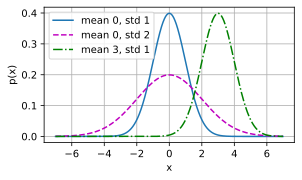

In [18]:
x = np.arange(-7,7,0.01)

params = [(0, 1),(0,2),(3,1)]
d2l.plot(x, [normal(x,mu,sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5,2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## Linear Regression implementation from Scratch

In [19]:
import random

In [22]:
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1,1))

In [23]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [26]:
print(f'features: {features[0]}\nlabel: {labels[0]}')

features: tensor([ 0.3437, -0.0128])
label: tensor([4.9226])


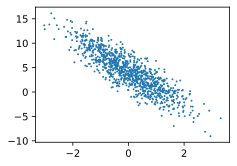

In [27]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(), labels.detach().numpy(), 1)

### Reading the Dataset

In [34]:
 def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # 한 번에 batch_size 길이의 batch indices 생성
        batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)]) # min으로 걸어주는 이유는 마지막에 데이터가 조금만 남는 경우를 고려해서

        yield features[batch_indices], labels[batch_indices] # generator로 미니 배치 리턴

In [35]:
batch_size = 10

In [36]:
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4786, -0.7745],
        [-0.2059, -1.5791],
        [ 0.7372, -0.9116],
        [-0.8075, -1.0293],
        [ 0.3047, -1.4244],
        [ 0.0728,  1.2501],
        [ 1.2415, -2.7750],
        [-2.2121, -0.8243],
        [ 0.6180, -0.7280],
        [ 0.6331,  2.0512]]) 
 tensor([[ 5.8756],
        [ 9.1546],
        [ 8.7624],
        [ 6.0806],
        [ 9.6290],
        [ 0.0909],
        [16.1292],
        [ 2.5758],
        [ 7.9071],
        [-1.4868]])


In [37]:
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)

tensor([[ 1.4133,  0.2886],
        [ 0.7766, -0.4960],
        [ 1.3122,  1.1477],
        [ 0.2174, -0.4191],
        [ 0.1706, -0.4711],
        [ 1.9230,  0.0899],
        [-2.6866, -0.3913],
        [-1.6228,  0.4658],
        [ 1.2088,  1.2567],
        [ 0.5976, -1.0020]]) 
 tensor([[ 6.0213],
        [ 7.4246],
        [ 2.9382],
        [ 6.0596],
        [ 6.1519],
        [ 7.7244],
        [ 0.1501],
        [-0.6228],
        [ 2.3550],
        [ 8.8142]])
tensor([[-1.5009e+00,  9.6556e-01],
        [ 5.5545e-01, -7.7021e-01],
        [-4.8412e-01,  2.3614e-01],
        [-6.5909e-01,  1.9776e+00],
        [-3.4476e-01,  1.9639e+00],
        [ 3.8558e-01,  1.1121e-03],
        [-5.9485e-01,  2.9765e-01],
        [ 2.3498e-01,  2.0024e+00],
        [ 1.4878e-01,  3.4326e-02],
        [-9.0594e-01,  6.0744e-01]]) 
 tensor([[-2.0932],
        [ 7.9415],
        [ 2.4212],
        [-3.8370],
        [-3.1697],
        [ 4.9744],
        [ 2.0033],
        [-2.1293],
        [ 4

 tensor([[ 3.5909],
        [ 7.4580],
        [ 1.4983],
        [-0.5109],
        [ 6.0657],
        [ 4.5426],
        [ 1.2106],
        [-2.2157],
        [ 2.5989],
        [ 1.5285]])
tensor([[ 0.2468, -1.3963],
        [-0.8173,  0.1752],
        [ 0.6870,  0.8937],
        [-0.6756, -0.7023],
        [-0.4885, -0.0951],
        [ 1.2504, -0.3234],
        [-0.2344,  0.6913],
        [ 1.1440, -0.9056],
        [ 1.3222,  0.6123],
        [-1.9916, -0.5216]]) 
 tensor([[9.4421],
        [1.9699],
        [2.5217],
        [5.2338],
        [3.5619],
        [7.7907],
        [1.3842],
        [9.5676],
        [4.7637],
        [1.9946]])
tensor([[ 2.1166,  0.4549],
        [-0.4786, -0.7745],
        [-1.4950,  2.7521],
        [-0.1399,  1.6293],
        [ 0.1864,  0.4537],
        [ 0.0079,  1.8442],
        [-0.5168, -0.2477],
        [ 0.0330,  0.3478],
        [-1.7623, -1.3401],
        [-0.0810,  0.2546]]) 
 tensor([[ 6.8693],
        [ 5.8756],
        [-8.1403],
    

 tensor([[11.5670],
        [ 8.7624],
        [11.2693],
        [ 0.2474],
        [-0.9915],
        [ 5.1789],
        [ 9.1748],
        [11.5526],
        [-0.8251],
        [ 3.5818]])
tensor([[ 0.7585, -1.8676],
        [ 0.6853, -1.5184],
        [-0.2904, -0.6977],
        [ 0.7820,  0.8449],
        [ 0.4551, -0.8936],
        [-0.0144, -0.0513],
        [ 0.9199, -0.3345],
        [ 0.9537, -1.0635],
        [ 1.1539,  1.7723],
        [-1.1069,  1.6222]]) 
 tensor([[12.0508],
        [10.7270],
        [ 5.9802],
        [ 2.8876],
        [ 8.1678],
        [ 4.3321],
        [ 7.1709],
        [ 9.7155],
        [ 0.4724],
        [-3.5299]])
tensor([[-0.1299, -0.5760],
        [-1.3377, -0.5952],
        [-0.3706, -1.7566],
        [ 0.7973,  1.0360],
        [ 1.8300,  0.3878],
        [-0.0104, -0.4116],
        [-0.7231, -0.2883],
        [ 0.1499,  0.5958],
        [ 0.3720,  0.9077],
        [-1.3989, -0.9122]]) 
 tensor([[5.9085],
        [3.5565],
        [9.4324

### Initializaing Model Parameters

In [39]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad = True) 
b = torch.zeros(1, requires_grad = True)

requires_grad를 True로 두면 auto-diff가 적용이 되니까 이렇게 parameter register해주는 거..

### Defining the Model 

In [41]:
def linreg(X,w,b): # simple regression model
    return torch.matmul(X,w) + b

### Defining the Loss Function

In [42]:
def squared_loss(y_hat, y):
    """
    squared loss
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### Defining the Optimization Algorithm

In [43]:
def sgd(params, lr, batch_size):
    """
    minibatch stochastic gradient descent
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

1. batch_size로 나누는 이유
→ 일종의 normalize. batch_size로 나눠줌으로써 gradient가 batch size에 큰 영향을 받지 않도록 함.

2. gradient를 zero로 해주는 이유 (이 부분은 좀 더 찾아보기)
→ 이전 step의 gradient가 누적되지 않도록 함.

### Training

In [44]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [45]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b), y)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038385
epoch 2, loss 0.000139
epoch 3, loss 0.000049


In [46]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0006], grad_fn=<RsubBackward1>)


## 3.3. Consise Implementation of Lineaer Regression

###  Generating the Dataset

In [47]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [50]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### Reading the Dataset

In [51]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [52]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [53]:
next(iter(data_iter))

[tensor([[-0.6706, -0.5701],
         [ 0.9466,  0.0927],
         [-0.0165, -1.4457],
         [-0.0732, -0.8479],
         [-0.2075,  1.7521],
         [ 1.5033, -0.0230],
         [-1.2646, -0.5753],
         [ 0.8455, -1.4574],
         [ 1.3123,  0.0091],
         [ 0.3649,  0.6621]]),
 tensor([[ 4.7888],
         [ 5.7726],
         [ 9.0756],
         [ 6.9366],
         [-2.1613],
         [ 7.2931],
         [ 3.6275],
         [10.8394],
         [ 6.8045],
         [ 2.6686]])]

### Defining the Model

In [54]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

### Initializaing Model Parameters

In [55]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### Defining the Loss Function

In [56]:
loss = nn.MSELoss()

### Defining the Optimization Algorithm

In [57]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

### Training

In [58]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    

epoch 1, loss 0.000199
epoch 2, loss 0.000098
epoch 3, loss 0.000098


In [59]:
w = net[0].weight.data
print('error in estimating w: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b: ', true_b - b)

error in estimating w:  tensor([0.0006, 0.0011])
error in estimating b:  tensor([0.0005])
